 --------------------------------------------------------------------------

               Astra- A space charge tracking algorithm
                  Version 4.0 - macOS 64bit - Intel   
                        DESY,  Hamburg 2022          
                        Fri Apr 19 14:37:30 

     Parameter file is:  astra.in                                          
     TNSA SC Analysis                                                                

 Initialize element settings:
     neglecting space charge forces 

 --------------------------------------------------------------------------
 Aperture:

 --------------------------------------------------------------------------
 Solenoid:

     Reading solenoid field data from:    light_solenoid.dat                                                              
     field smoothing is applied
     maximum |Bz| field                     9.900     T
     at                                     0.000     m
     integral Bz squared              

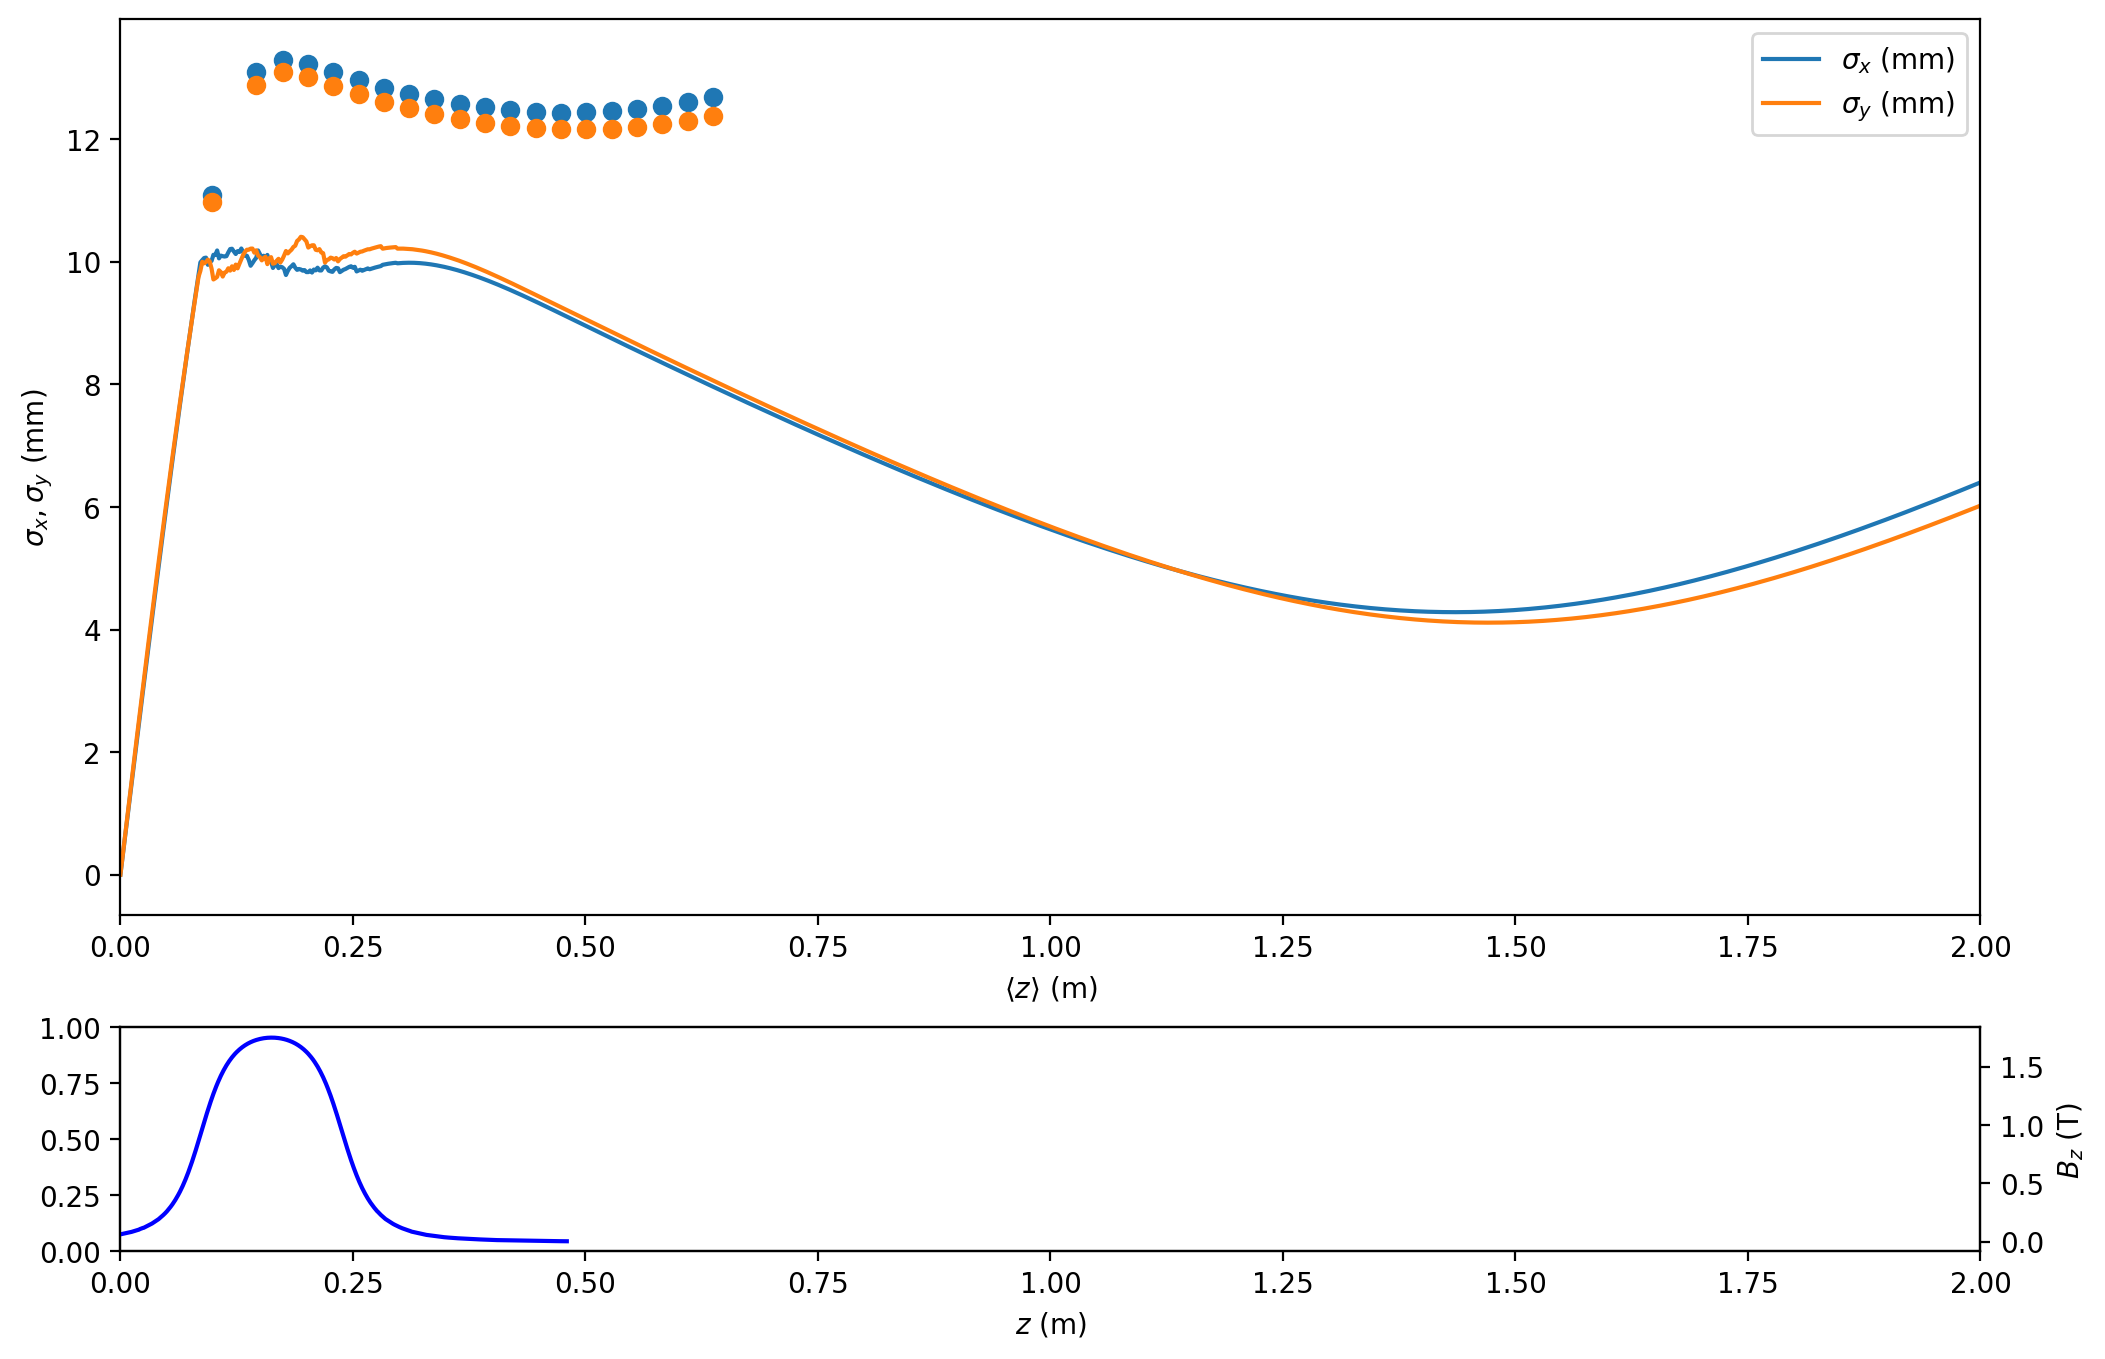

In [44]:
from astra import Astra

import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
import Methods
import scipy.constants as const

matplotlib.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

A0 = Astra("astra.in")

b_field = 9.9
A0.input['solenoid']['MaxB(1)'] = b_field
A0.input['newrun']['zstop'] = 2
A0.timeout = None
A0.verbose = True

#Run
A0.run()
A0.plot()


Initial particles written to /var/folders/5y/_90vwzcx7wj7j56tcpjbgtz00000gn/T/tmpubynfuhc/astra.particles
 --------------------------------------------------------------------------

               Astra- A space charge tracking algorithm
                  Version 4.0 - macOS 64bit - Intel   
                        DESY,  Hamburg 2022          
                        Fri Apr 19 15:14:29 

     Parameter file is:  astra.in                                          
     TNSA SC Analysis                                                                

 Initialize element settings:
     neglecting space charge forces 

 --------------------------------------------------------------------------
 Aperture:

 --------------------------------------------------------------------------
 Solenoid:

     Reading solenoid field data from:    light_solenoid.dat                                                              
     field smoothing is applied
     maximum |Bz| field                     

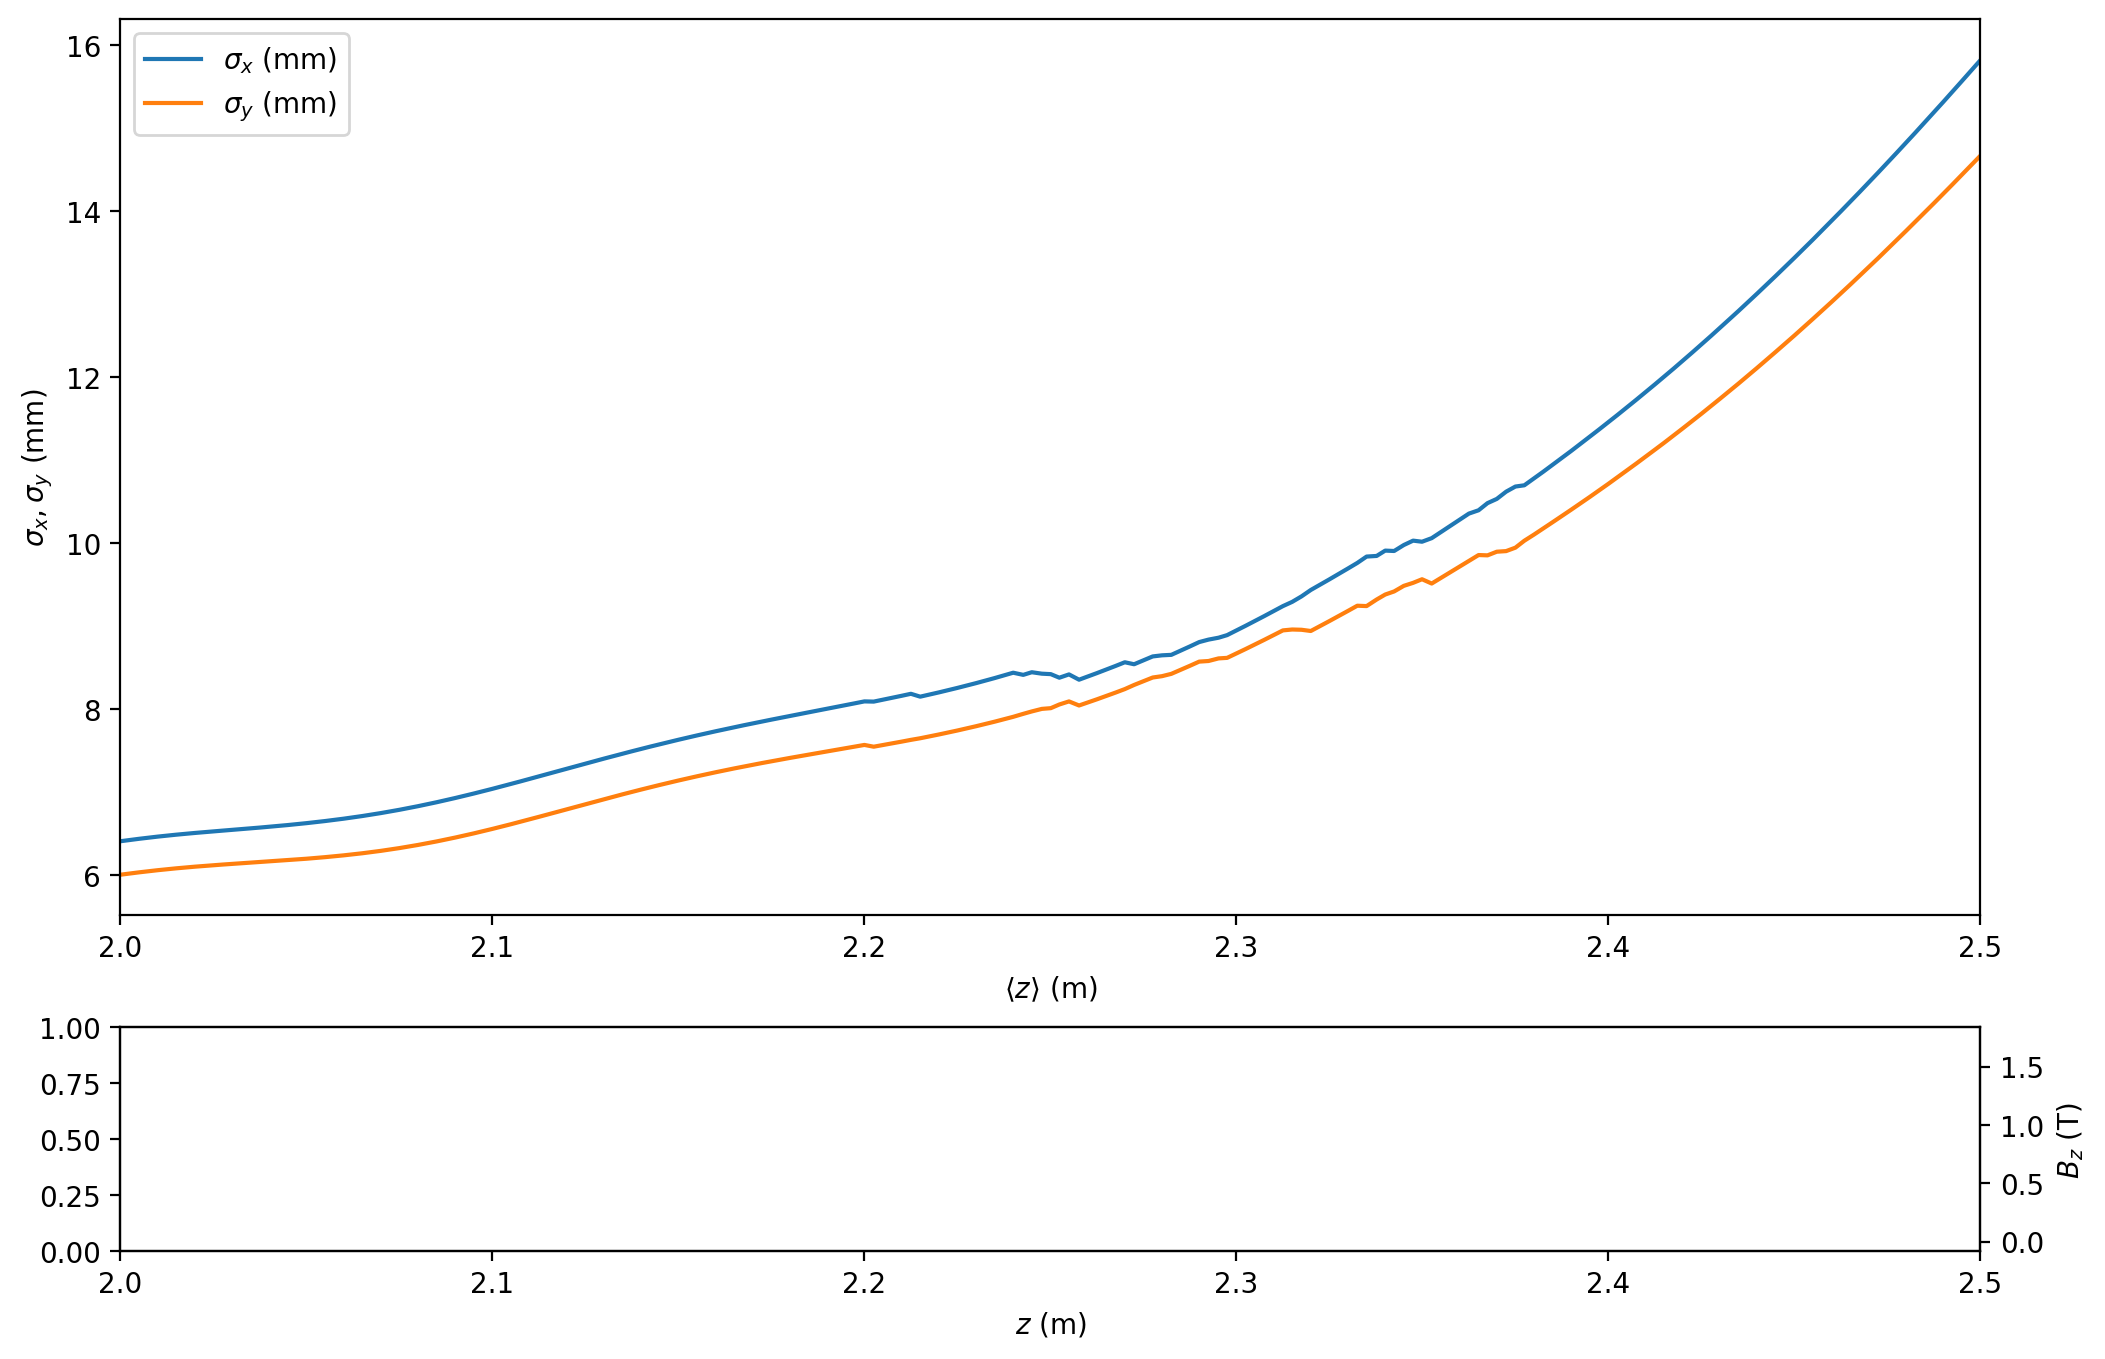

In [49]:


output_particles = A0.output["particles"][-1]

A1 = Astra("astra.in")

b_field = 30


A1.input['solenoid']['MaxB(1)'] = b_field
A1.input['solenoid']['S_pos(1)'] = 2

A1.input['aperture']['Ap_Z1(1)'] = 2.04
A1.input['aperture']['Ap_Z2(1)'] = 2.34

A1.verbose = True
A1.track(output_particles,2.5)

A1.plot()



Text(0.5, 0, 'Y (mm)')

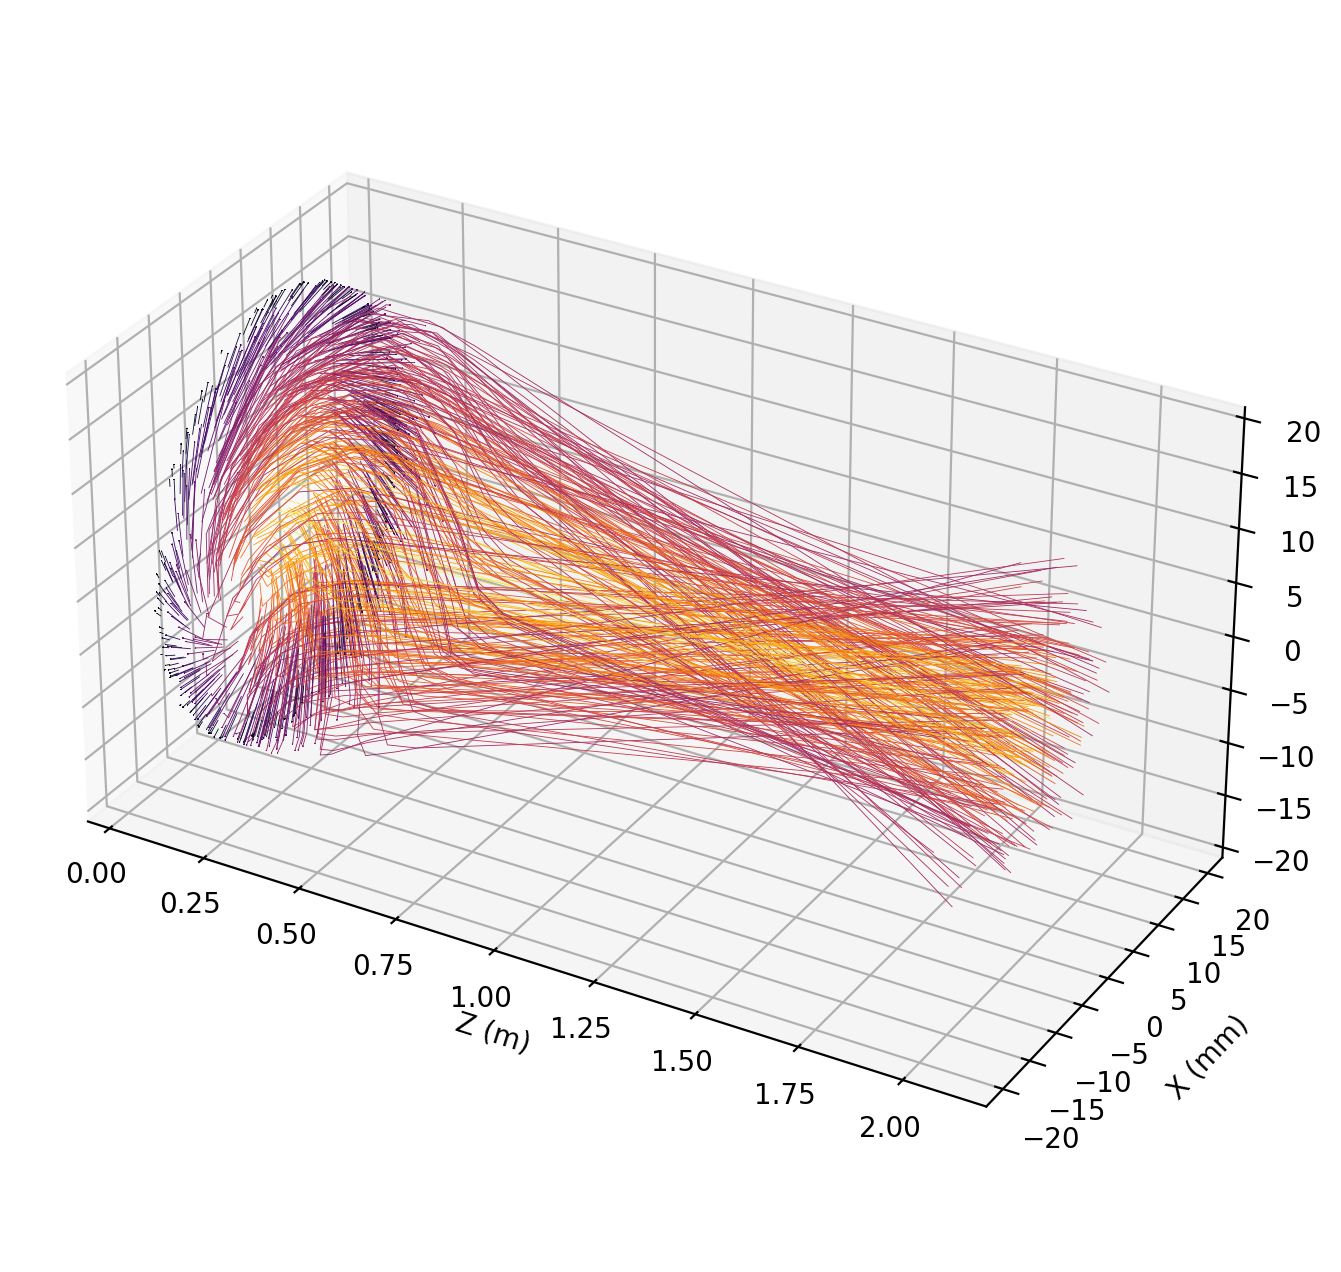

In [50]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = matplotlib.colormaps.get_cmap('inferno')

skip=1
X = np.array([P0.x for P0 in  A0.particles]).T[::skip]
Y = np.array([P0.y for P0 in  A0.particles]).T[::skip]
Z = np.array([P0.z for P0 in  A0.particles]).T[::skip]

scale = np.hypot(X[:, 0], Y[:,0]).max()

# color by  initial radius
for i in range(len(X)):
    color = cmap(1-np.hypot(X[i,0], Y[i,0])/scale)
    ax.plot(X[i]*1e3, Y[i]*1e3, Z[i], zdir='x', color=color, linewidth=.3)

ax.set_box_aspect((2,1,1))    
    
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (mm)')
ax.set_zlabel('Y (mm)')

Text(0.5, 0, 'Y (mm)')

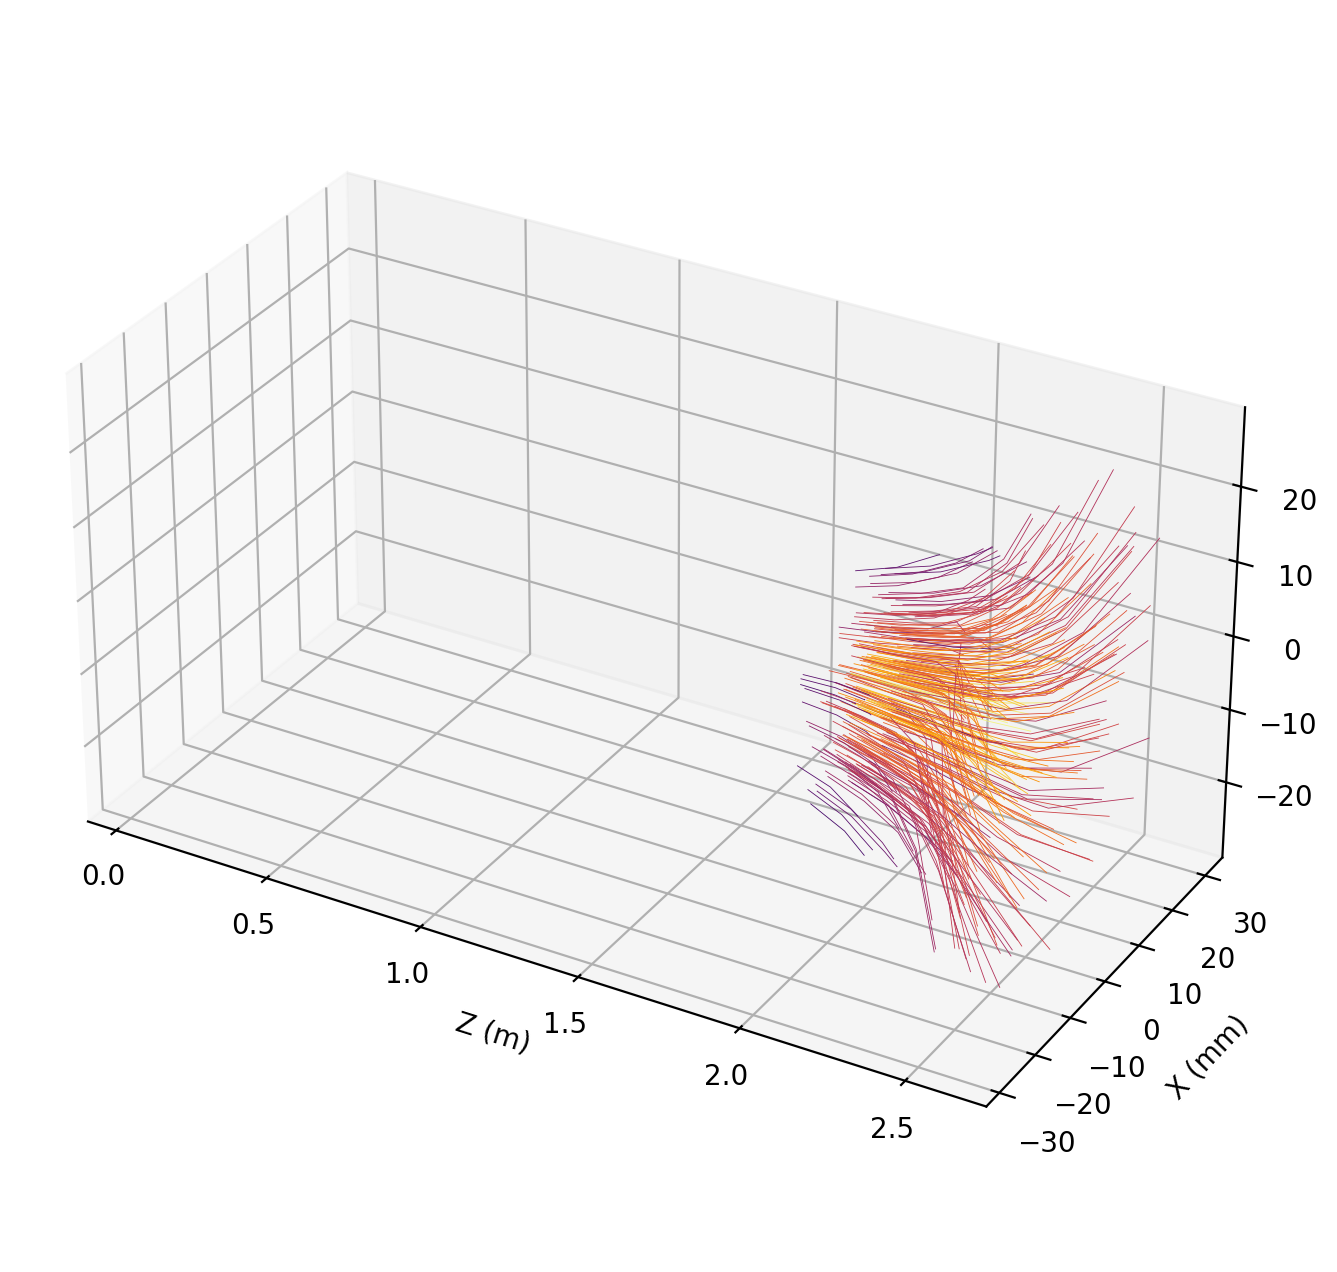

In [51]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = matplotlib.colormaps.get_cmap('inferno')

skip=1
X = np.array([P0.x for P0 in  A1.particles]).T[::skip]
Y = np.array([P0.y for P0 in  A1.particles]).T[::skip]
Z = np.array([P0.z for P0 in  A1.particles]).T[::skip]

scale = np.hypot(X[:, 0], Y[:,0]).max()

# color by  initial radius
for i in range(len(X)):
    color = cmap(1-np.hypot(X[i,0], Y[i,0])/scale)
    ax.plot(X[i]*1e3, Y[i]*1e3, Z[i], zdir='x', color=color, linewidth=.3)

ax.set_box_aspect((2,1,1))    
    
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (mm)')
ax.set_zlabel('Y (mm)')